This script uses geopandas to read the census information of Pittburgh.

# Installing Libraries

While most basic Python Libraries taht are used in this notebook are pre-installed on your system, you might want to install additional libraries. The following code is tested on Linux OS, Python 2.7.

You can install GeoPandas, Shapely (automatically installed as a dependency of GeoPandas), and GeoPy using pip. Additionally, you might have to install Rtree to install relevant geopandas dependency.

    $ pip install --upgrade geopandas geopy
$ conda install -c ioos rtree

To ensue that all the packages have been installed correctly, please run the following code. If error still persists, you might want to look at the original documentation for troubleshooting.

In [1]:
import geopandas as gpd
import shapely
from geopy.geocoders import GoogleV3
import rtree
import fiona

Additional libraries:

In [2]:
import os
import csv
import zipfile
import string
import pandas as pd
import datetime as dt
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("white")
%matplotlib inline

## Load Census info

In [4]:
# Set location of file
filepath = "../Dataset/ACS_2014_5YR_TRACT_42.gdb.zip"
filepath

'../Dataset/ACS_2014_5YR_TRACT_42.gdb.zip'

In [5]:
fiona.listlayers(filepath)

['ACS_2014_5YR_TRACT_42_PENNSYLVANIA',
 'TRACT_METADATA_2014',
 'X00_COUNTS',
 'X01_AGE_AND_SEX',
 'X02_RACE',
 'X03_HISPANIC_OR_LATINO_ORIGIN',
 'X04_ANCESTRY',
 'X05_FOREIGN_BORN_CITIZENSHIP',
 'X06_PLACE_OF_BIRTH',
 'X07_MIGRATION',
 'X08_COMMUTING',
 'X09_CHILDREN_HOUSEHOLD_RELATIONSHIP',
 'X10_GRANDPARENTS_GRANDCHILDREN',
 'X11_HOUSEHOLD_FAMILY_SUBFAMILIES',
 'X12_MARITAL_STATUS_AND_HISTORY',
 'X13_FERTILITY',
 'X14_SCHOOL_ENROLLMENT',
 'X15_EDUCATIONAL_ATTAINMENT',
 'X16_LANGUAGE_SPOKEN_AT_HOME',
 'X17_POVERTY',
 'X18_DISABILITY',
 'X19_INCOME',
 'X20_EARNINGS',
 'X21_VETERAN_STATUS',
 'X22_FOOD_STAMPS',
 'X23_EMPLOYMENT_STATUS',
 'X24_INDUSTRY_OCCUPATION',
 'X25_HOUSING_CHARACTERISTICS',
 'X26_GROUP_QUARTERS',
 'X27_HEALTH_INSURANCE',
 'X99_IMPUTATION']

Metadata of column shortnames

In [6]:
df_metadata = gpd.read_file(filepath, layer="TRACT_METADATA_2014");
df_metadata.head()

,Full_Name,Short_Name,geometry
0,UNWEIGHTED SAMPLE COUNT OF THE POPULATION: Tot...,B00001e1,None
1,UNWEIGHTED SAMPLE COUNT OF THE POPULATION: Tot...,B00001m1,None
2,UNWEIGHTED SAMPLE HOUSING UNITS: Total: Housin...,B00002e1,None
3,UNWEIGHTED SAMPLE HOUSING UNITS: Total: Housin...,B00002m1,None
4,SEX BY AGE: Total: Total population -- (Estimate),B01001e1,None


In [7]:
len(df_metadata)

35344

Income data for tracts

In [8]:
df_income = gpd.read_file(filepath, layer="X19_INCOME");
df_income.head()

,B19001Ae1,B19001Ae10,B19001Ae11,B19001Ae12,B19001Ae13,B19001Ae14,B19001Ae15,B19001Ae16,B19001Ae17,B19001Ae2,...,B19326e7,B19326m1,B19326m2,B19326m3,B19326m4,B19326m5,B19326m6,B19326m7,GEOID,geometry
0,929,39,83,143,186,123,72,64,38,20,...,11038.0,3242.0,6464.0,8774.0,11889.0,4817.0,5275.0,2063.0,14000US42001030101,None
1,2149,120,244,347,337,214,125,71,58,14,...,11630.0,2262.0,6865.0,6585.0,3613.0,5289.0,12849.0,2947.0,14000US42001030102,None
2,1850,68,227,143,291,200,75,53,30,50,...,12418.0,1925.0,2770.0,3066.0,2107.0,2990.0,3906.0,1231.0,14000US42001030200,None
3,1441,49,191,175,321,121,52,33,48,45,...,13775.0,2590.0,4893.0,5220.0,3467.0,4741.0,6186.0,3249.0,14000US42001030300,None
4,2127,50,92,303,226,151,201,117,74,104,...,13513.0,3654.0,4830.0,5447.0,6358.0,7768.0,2851.0,2771.0,14000US42001030400,None


In [9]:
len(df_income)

3218

In [10]:
# df_poverty = gpd.read_file(filepath, layer="X17_POVERTY");
# df_poverty.head()

In [11]:
# fullname = []
# for colname in df_poverty.columns:
#     fullname.append(df_metadata.Full_Name[df_metadata.Short_Name == colname].values)

Selecting 1/2994 column from income df that best describes the wealth level of a tract

In [12]:
fullname = []
for colname in df_income.columns:
    fullname.extend(df_metadata.Full_Name[df_metadata.Short_Name == colname].values)

In [13]:
fullname[:2]

[u'HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2014 INFLATION-ADJUSTED DOLLARS) (WHITE ALONE HOUSEHOLDER): Total: Households with a householder who is White alone -- (Estimate)',
 u'HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2014 INFLATION-ADJUSTED DOLLARS) (WHITE ALONE HOUSEHOLDER): $45,000 to $49,999: Households with a householder who is White alone -- (Estimate)']

In [14]:
sub = 'ALONE'
# sub1 = 'WHITE ALONE'
# sub2 = 'BLACK OR AFRICAN AMERICAN ALONE'
# sub3 = 'AMERICAN INDIAN AND ALASKA NATIVE ALONE'
# sub4 = 'ASIAN ALONE'
# sub5 = 'NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE'
# sub6 = 'SOME OTHER RACE ALONE'
sub1 = 'HISPANIC OR LATINO'
sub2 = 'RACE'
sub3 = 'FAMILY'
sub4 = 'BY'
temp = []
names = []
shortname = []
for val in fullname:
    if sub not in val and \
        sub1 not in val and \
        sub2 not in val and \
        sub3 not in val and \
        sub4 not in val and \
        '$' not in val and \
        'Quintile' not in val and \
        'Estimate' in val and \
        'Total' in val and \
        'DIVIDENDS' not in val and \
        'OTHER' not in val and \
        'ASSISTANCE' not in val and \
        'RETIREMENT' not in val and \
        'EMPLOYMENT' not in val and \
        'SUPPLEMENTAL' not in val and \
        'SECURITY' not in val and \
        'WAGE' not in val and \
        '(IN 2014 INFLATION-ADJUSTED DOLLARS)' in val:
        index = val.index('IN THE PAST')
        names.append(val)
        shortname.extend(df_metadata.Short_Name[df_metadata.Full_Name == val].values)

In [15]:
len(names)

6

In [16]:
shortname

[u'B19001e1', u'B19013e1', u'B19025e1', u'B19061e1', u'B19301e1', u'B19313e1']

In [17]:
df_metadata[df_metadata.Short_Name.isin(shortname)]

,Full_Name,Short_Name,geometry
18942,HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 201...,B19001e1,None
19282,MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS ...,B19013e1,None
19318,AGGREGATE HOUSEHOLD INCOME IN THE PAST 12 MONT...,B19025e1,None
20798,AGGREGATE EARNINGS IN THE PAST 12 MONTHS (IN 2...,B19061e1,None
21690,PER CAPITA INCOME IN THE PAST 12 MONTHS (IN 20...,B19301e1,None
21710,AGGREGATE INCOME IN THE PAST 12 MONTHS (IN 201...,B19313e1,None


In [18]:
for n in names:
    print n, '\n'

HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2014 INFLATION-ADJUSTED DOLLARS): Total: Households -- (Estimate) 

MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2014 INFLATION-ADJUSTED DOLLARS): Total: Households -- (Estimate) 

AGGREGATE HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2014 INFLATION-ADJUSTED DOLLARS): Total: Households -- (Estimate) 

AGGREGATE EARNINGS IN THE PAST 12 MONTHS (IN 2014 INFLATION-ADJUSTED DOLLARS) FOR HOUSEHOLDS: Total: Households -- (Estimate) 

PER CAPITA INCOME IN THE PAST 12 MONTHS (IN 2014 INFLATION-ADJUSTED DOLLARS): Total: Total population -- (Estimate) 

AGGREGATE INCOME IN THE PAST 12 MONTHS (IN 2014 INFLATION-ADJUSTED DOLLARS): Total: Population 15 years and over -- (Estimate) 



In [19]:
df_income[shortname].head()

,B19001e1,B19013e1,B19025e1,B19061e1,B19301e1,B19313e1
0,952,79048.0,89068400.0,73286700.0,34579.0,89526300.0
1,2194,64561.0,169066100.0,135867300.0,29509.0,170913300.0
2,1988,52113.0,126826500.0,103615300.0,24660.0,127764700.0
3,1542,60556.0,111007100.0,90098600.0,26517.0,113147400.0
4,2215,60232.0,166286400.0,129561600.0,29219.0,171571900.0


Here, we plan to choose 'B19013e1': MEDIAN HOUSEHOLD INCOME

In [20]:
df_geodata = gpd.read_file(filepath)
df_geodata.head()

,ALAND,AWATER,COUNTYFP,FUNCSTAT,GEOID,GEOID_Data,INTPTLAT,INTPTLON,MTFCC,NAME,NAMELSAD,STATEFP,Shape_Area,Shape_Length,TRACTCE,geometry
0,7608630.0,2509724.0,017,S,42017100102,14000US42017100102,+40.0745595,-074.9405810,G5020,1001.02,Census Tract 1001.02,42,0.001068,0.189252,100102,(POLYGON ((-74.98425399982222 40.0559019997775...
1,1572547.0,9817.0,017,S,42017100103,14000US42017100103,+40.0687610,-074.9713318,G5020,1001.03,Census Tract 1001.03,42,0.000167,0.070063,100103,(POLYGON ((-74.98489299961221 40.0572869997952...
2,2409070.0,35484.0,091,S,42091201411,14000US42091201411,+40.1444849,-075.2140269,G5020,2014.11,Census Tract 2014.11,42,0.000258,0.099649,201411,(POLYGON ((-75.23313900006474 40.1509280004269...
3,1966899.0,12199.0,017,S,42017100104,14000US42017100104,+40.0918428,-074.9501748,G5020,1001.04,Census Tract 1001.04,42,0.000209,0.087246,100104,(POLYGON ((-74.96488299955075 40.0772729996492...
4,2663937.0,0.0,017,S,42017100105,14000US42017100105,+40.0821350,-074.9478227,G5020,1001.05,Census Tract 1001.05,42,0.000281,0.079053,100105,(POLYGON ((-74.96310300020326 40.0729419995736...


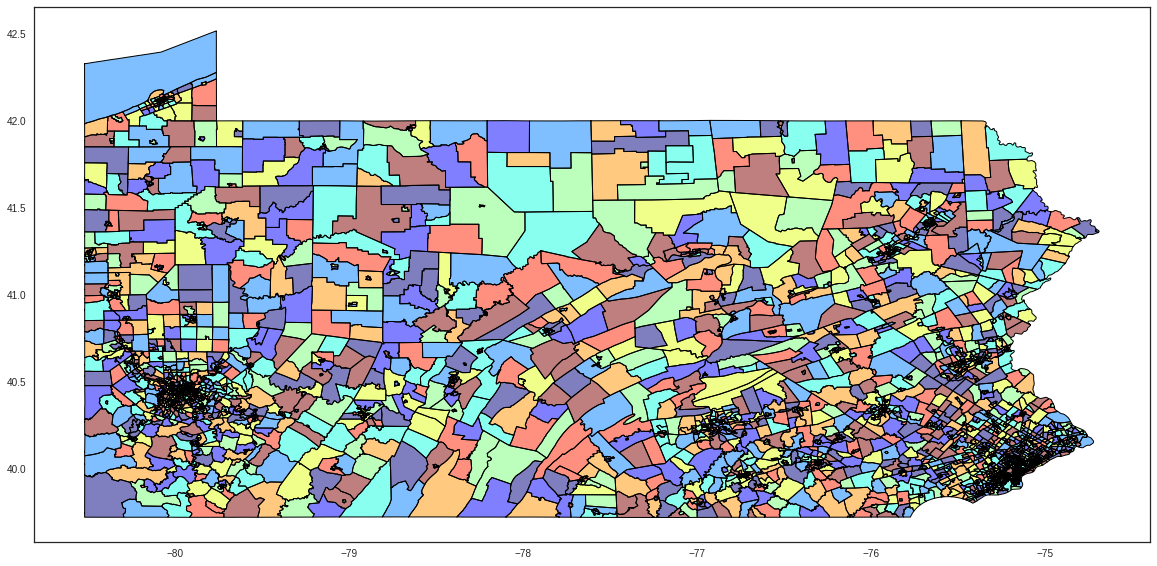

In [21]:
df_geodata.plot(figsize=(20,20), cmap="jet")

In [22]:
df_geodata.geometry[0].geom_type

'MultiPolygon'

In [23]:
len(df_geodata)

3218

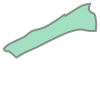

In [24]:
df_geodata.geometry[0]

In [25]:
# Returns a Series containing the area of each geometry in the GeoSeries.
df_geodata.geometry[0].area

0.0010682363326908893

In [26]:
# Returns a Series containing the length of each geometry.
df_geodata.geometry[0].length

0.18925224827526602

In [27]:
# Returns a DataFrame with columns minx, miny, maxx, maxy values containing the bounds for each geometry.
df_geodata.geometry[0].bounds

(-74.98430200023711,
 40.048595000059265,
 -74.90883100025042,
 40.092551000028664)

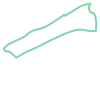

In [29]:
df_geodata.geometry[0].boundary

In [28]:
df_geodata.geometry[0].centroid.bounds[:2]

(-74.94246670000071, 40.07059639746169)

In [30]:
df_geodata.geometry[0].centroid.x

-74.94246670000071

In [31]:
df_geodata.geometry[0].centroid.y

40.07059639746169

In [ ]:
# import pprint
# pprint.pprint(df_geodata.geometry)

# Final DF

In [33]:
df_final= pd.DataFrame()

In [34]:
df_final['GEOID'] = df_geodata.GEOID_Data

In [35]:
df_final['Centroid_X'] = df_geodata.geometry.centroid.map(lambda p: p.x)

In [36]:
df_final['Centroid_Y'] = df_geodata.geometry.centroid.map(lambda p: p.y)

In [37]:
df_final = pd.merge(df_final, df_income[['GEOID','B19013e1']],on='GEOID',how='inner')

In [38]:
df_final.rename(columns={'B19013e1': 'MEDIAN_INCOME'}, inplace=True)

In [39]:
df_final

,GEOID,Centroid_X,Centroid_Y,MEDIAN_INCOME
0,14000US42017100102,-74.942467,40.070596,49269.0
1,14000US42017100103,-74.971613,40.068321,46595.0
2,14000US42091201411,-75.212998,40.143863,89006.0
3,14000US42017100104,-74.955745,40.089675,39839.0
4,14000US42017100105,-74.947822,40.082135,69688.0
5,14000US42017100206,-74.944171,40.134779,75948.0
6,14000US42017101404,-75.001047,40.161721,85469.0
7,14000US42101036501,-75.013196,40.129321,46397.0
8,14000US42101000801,-75.180051,39.950060,81667.0
9,14000US42017100207,-74.945209,40.120890,43387.0
